# Text Tasks without Neural Networks

Natural language processing (NLP) is often associated with deep learning and neural networks. However, there are efficient methods for text classification that do not rely on neural networks. In this exploration, we will demonstrate a sentiment analysis classification problem using text embeddings combined with traditional machine learning algorithms.

The task at hand is sentiment analysis: classifying tweets as positive, negative, neutral, or irrelevant. Sentiment analysis determines the emotional tone of text. Although neural networks, particularly models like BERT, are popular for this task, traditional machine learning algorithms can also be effective when used with modern text embeddings.

We will use a Twitter dataset containing labeled tweets to classify their sentiment. Our approach involves using the BERT tokenizer and embeddings (we previously [looked at the basics of embeddings](gensim)) for text preprocessing, followed by traditional machine learning algorithms for classification.

Using traditional machine learning algorithms offers several advantages. They are generally faster and require less computational power compared to deep learning models, making them suitable for resource-limited scenarios. Additionally, traditional algorithms are often easier to interpret, providing more transparency in decision-making processes. Moreover, traditional algorithms can achieve competitive performance when combined with powerful text embeddings like those from BERT.

## Loading and understanding the data

Let’s start by loading the dataset and understanding its structure. The dataset contains tweets labeled as positive, negative, neutral, or irrelevant. We will load the data and examine a few samples to understand the text and labels.

In [1]:
# Download the dataset

!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis -p .data/ --unzip

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 4.38MB/s]
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 3.96MB/s]


In [2]:
# Load dataset
import pandas as pd
import numpy as np

sentiment = pd.read_csv('.data/twitter_training.csv')
sentiment_validation = pd.read_csv('.data/twitter_validation.csv')

# Add column names
sentiment.columns = ['id', 'tag', 'sentiment', 'text']
sentiment_validation.columns = ['id', 'tag', 'sentiment', 'text']

sentiment

,id,tag,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


Let's count the number of samples for each sentiment category in the dataset, so we can understand the distribution of labels.

In [3]:
sentiment['sentiment'].value_counts()

sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Note how the `Irrelevant` category has the least number of samples, which might pose a challenge for training a classifier. Let us also check the category distribution for the validation set.

In [4]:
sentiment_validation['sentiment'].value_counts()

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64

Before continuing, we will also drop any rows with missing values in the text column.

In [5]:
# Validate that 'text' is not null or empty
sentiment = sentiment.dropna(subset=['text'])
sentiment_validation = sentiment_validation.dropna(subset=['text'])

## Calculating embeddings using BERT

We will be using the [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) model for generating embeddings for the text data. BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained language model that can be fine-tuned for various NLP tasks. In this case, we will use BERT to generate embeddings for the tweets in our dataset.

We have explored BERT embeddings in a [previous experiment](bert-emotions). As reference, in that experiment, a fine tuned BERT model achieved an accuracy of $\mathbf{0.87}$.

In [6]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pandas as pd

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to compute the embedding for a single sentence
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=512)
    outputs = bert_model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()

# Function to compute embeddings for a batch of sentences
def get_embeddings_batch(texts):
    inputs = tokenizer(texts, return_tensors='tf', truncation=True, padding=True, max_length=512)
    outputs = bert_model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()

# Convert text columns to lists
sentiment_texts = sentiment['text'].tolist()
sentiment_validation_texts = sentiment_validation['text'].tolist()

# Batch size for processing
batch_size = 64

# Compute embeddings in batches for the sentiment DataFrame
sentiment_embeddings = []
for i in range(0, len(sentiment_texts), batch_size):
    batch_texts = sentiment_texts[i:i+batch_size]
    batch_embeddings = get_embeddings_batch(batch_texts)
    sentiment_embeddings.extend(batch_embeddings)
    if (i // batch_size) % 20 == 0:
        print(f'Processed {i} sentences', end='\r')

# Add the embeddings to the sentiment DataFrame using .loc
sentiment.loc[:, 'embedding'] = sentiment_embeddings

# Compute embeddings in batches for the sentiment_validation DataFrame
sentiment_validation_embeddings = []
for i in range(0, len(sentiment_validation_texts), batch_size):
    batch_texts = sentiment_validation_texts[i:i+batch_size]
    batch_embeddings = get_embeddings_batch(batch_texts)
    sentiment_validation_embeddings.extend(batch_embeddings)
    if (i // batch_size) % 20 == 0:
        print(f'Processed {i} validation sentences', end='\r')

# Add the embeddings to the sentiment_validation DataFrame using .loc
sentiment_validation.loc[:, 'embedding'] = sentiment_validation_embeddings


2024-05-27 01:25:34.574831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-27 01:25:34.574898: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-05-27 01:25:34.574917: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-05-27 01:25:34.574951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-27 01:25:34.574971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.La

/var/folders/y6/pdtk142j2hs__2lwm72sfv2m0000gn/T/ipykernel_9734/3510202729.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment.loc[:, 'embedding'] = sentiment_embeddings


Let's check what the embeddings look like for a sample tweet.

In [7]:
# Show a few random samples of the sentiment DataFrame
sentiment.sample(3, random_state=42)

,id,tag,sentiment,text,embedding
61734,4984,GrandTheftAuto(GTA),Irrelevant,Do you think you can hurt me?,"[0.08892427, 0.2648259, -0.0674681, -0.0081995..."
11260,13136,Xbox(Xseries),Positive,About The time!!,"[0.17830436, -0.0988084, 0.3218802, -0.0597304..."
55969,11207,TomClancysRainbowSix,Neutral,Calls from _ z1rv _ & @ Tweet98 got me this so...,"[0.16375747, -0.02854748, 0.36362436, -0.05746..."


Notice the computed embedding vector for the tweet. This vector captures the semantic information of the text, which can be used as input for traditional machine learning algorithms. Let us look at the embedding in more detail.

In [8]:
# Show the embedding for row 0 of the sentiment DataFrame, and its shape
print(sentiment.loc[0, 'embedding'])
print(sentiment.loc[0, 'embedding'].shape)

[ 1.24900751e-01  7.00786114e-02  4.89188433e-01  1.07170589e-01
 -3.19074988e-02 -1.55454859e-01  3.49471420e-01  3.61874998e-01
  9.18839723e-02 -4.36809391e-01 -1.83746144e-01  5.27964532e-02
 -2.69545048e-01  5.00030339e-01  1.56094193e-01  1.02434931e-02
 -1.62397578e-01  2.35131994e-01 -1.30412832e-01  2.72424400e-01
  1.64657593e-01  1.88282937e-01  8.95971730e-02 -4.27681133e-02
  2.54757583e-01  2.50094086e-01 -6.81025237e-02  1.23422049e-01
 -3.51504803e-01  1.93173755e-02  8.21451917e-02 -8.14978927e-02
  2.07479224e-02 -3.37027013e-02 -1.57258347e-01 -7.19650984e-02
 -7.95785785e-02 -3.02990805e-02 -3.46620947e-01  1.64861202e-01
 -2.99903899e-01 -4.70843576e-02  6.40956908e-02  3.72976214e-02
  1.04054026e-01 -3.74431252e-01  3.58513445e-01 -3.74675542e-02
 -7.53043517e-02 -1.28032371e-01 -7.58739933e-02  2.08849326e-01
 -3.65475148e-01 -1.71204373e-01  2.34705165e-01 -2.10490763e-01
 -3.70834827e-01 -4.70883042e-01 -4.69170958e-01  1.50728431e-02
  3.94148082e-01 -2.80514

The embedding vector has $\mathbf{768}$ dimensions, encoding the semantic information of the text data. Different models may have different embedding dimensions, but BERT embeddings are typically $\mathbf{768}$ or $\mathbf{1024}$ dimensions.

Let us also drop the `tag` and `id` columns from the training and validation sets, as they are not needed for classification.

In [9]:
# Drop the 'tag' and 'id' columns
sentiment = sentiment.drop(columns=['tag', 'id'])
sentiment_validation = sentiment_validation.drop(columns=['tag', 'id'])

And finally before we continue, let us evaluate the degree of separation between the classes in the embedding space. We will use [t-SNE](pca-vs-tsne) to visualize the embeddings in 2D space.

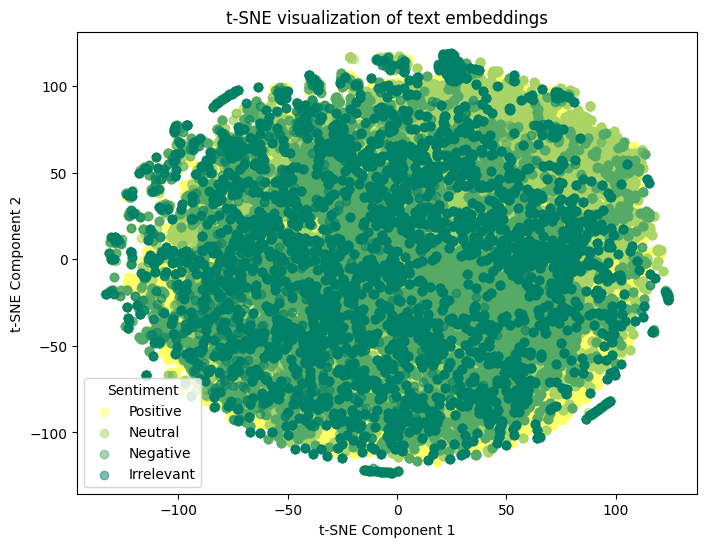

In [10]:
# Plot a t-SNE visualization of the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Copy the sentiment DataFrame to avoid modifying the original
sentiment_tsne = sentiment.copy()

# Convert sentiment labels to numerical values
sentiment_tsne['sentiment_num'] = sentiment['sentiment'].astype('category').cat.codes

# Compute a t-SNE embedding of the embeddings
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(np.stack(sentiment_tsne['embedding']))

# Plot the t-SNE visualization
plt.figure(figsize=(8, 6))

# Map the numerical values back to the original sentiment labels
unique_sentiments = sentiment_tsne['sentiment'].unique()
colors = plt.cm.summer_r(np.linspace(0, 1, len(unique_sentiments)))

# Create a scatter plot with a legend
for i, sentiment_label in enumerate(unique_sentiments):
    indices = sentiment_tsne['sentiment'] == sentiment_label
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=sentiment_label, c=[colors[i]], alpha=0.5)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE visualization of text embeddings')
plt.legend(title='Sentiment')
plt.show()

It's hard to discern much separation between the classes in the 2D t-SNE plot. This suggests that the classes are not easily separable in the embedding space, which might pose a challenge for classification.

## Evaluating traditional machine learning algorithms

In this experiment, we will evaluate the performance of both Random Forest and XGBoost classifiers on the dataset. We will train these classifiers on the BERT embeddings and evaluate their performance on the validation set.

Both [Random Forest](random-forests) and XGBoost are powerful ensemble learning algorithms that can handle high-dimensional data but may be prone to overfitting. We will tune their hyperparameters using grid search to optimize performance.

```{index} Cross validation
```

```{annotation} Cross validation
:class: note
Cross-validation is a technique used in machine learning to assess how a model will generalize to an independent dataset. It involves partitioning the original dataset into a set of training and validation subsets. The most common form of cross-validation is k-fold cross-validation, where the dataset is randomly divided into $\mathbf{k}$ equally sized folds.

The model is trained on $\mathbf{k-1}$ folds and tested on the remaining fold. This process is repeated $\mathbf{k}$ times, with each fold serving as the validation set once. The performance metric (such as accuracy, precision, recall, or mean squared error) is averaged over the k iterations to provide a more robust estimate of the model's performance.

This method helps in detecting overfitting and ensures that the model's evaluation is not overly dependent on a particular subset of the data. By using cross-validation, one can make better decisions about model selection and hyperparameter tuning, leading to more reliable and generalizable models.
```

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

# Define a wrapper class for XGBoost, so we can keep categories as strings
class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.params = params
        self.model = XGBClassifier(**params)
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        self.model.set_params(**self.params)
        self.model.fit(X, y_encoded)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        return self.label_encoder.inverse_transform(y_pred)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        self.model.set_params(**self.params)
        return self

# Assuming the embeddings are already added to the DataFrames

# Extract features (embeddings) and labels
X = np.vstack(sentiment['embedding'].values)
y = sentiment['sentiment'].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifiers and their respective parameter grids
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifierWrapper()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [200, 300],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 5]
    },
    'XGBoost': {
        'n_estimators': [200, 300],
        'max_depth': [3, 6],
        'reg_alpha': [0, 0.1], # L1 regularization term on weights
        'reg_lambda': [1, 2] # L2 regularization term on weights
    }
}

# Define a custom scoring function that balances precision, recall, and accuracy
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform grid search for each classifier, and store the best models
best_models = {}
for name, clf in classifiers.items():
    # Perform grid search with cross-validation, using f1 score as the metric (balancing precision and recall)
    grid_search = GridSearchCV(clf, param_grids[name], cv=3, scoring=scoring, n_jobs=-1, verbose=1, refit='f1')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'{name} best parameters:', grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/pedroleitao/.pyenv/versions/3.9.18/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/pedroleitao/.pyenv/versions/3.9.18/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost best parameters: {'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2}


We trained both Random Forest and XGBoost classifiers on the training set. We used the F1 score as the evaluation metric, as it provides a balance between precision and recall. The F1 score is particularly useful for imbalanced datasets, like the one we have, where the number of samples in each class is not equal. In particular, we used L1 and L2 regularization for XGBoost to prevent overfitting.

Now, we will evaluate the performance of the Random Forest and XGBoost classifiers on the validation set to choose the best performing model.

In [12]:
# Validation set
X_val = np.vstack(sentiment_validation['embedding'].values)
y_val = sentiment_validation['sentiment'].values
print(X_val.shape)
print(y_val.shape)

# Evaluate the best models on the validation set and choose the best one
best_model = None
best_accuracy = 0

for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    report_val = classification_report(y_val, y_val_pred)
    
    print(f'Validation Accuracy for {name}: {accuracy_val}')
    print(f'Classification Report for {name}:\n{report_val}\n')
    
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_model = model
        best_y_val_pred = y_val_pred

print(f'Best Model: {best_model}')
print(f'Best Validation Accuracy: {best_accuracy}')

(999, 768)
(999,)
Validation Accuracy for RandomForest: 0.7447447447447447
Classification Report for RandomForest:
              precision    recall  f1-score   support

  Irrelevant       0.99      0.49      0.65       171
    Negative       0.70      0.88      0.78       266
     Neutral       0.71      0.74      0.72       285
    Positive       0.76      0.79      0.77       277

    accuracy                           0.74       999
   macro avg       0.79      0.72      0.73       999
weighted avg       0.77      0.74      0.74       999


Validation Accuracy for XGBoost: 0.8128128128128128
Classification Report for XGBoost:
              precision    recall  f1-score   support

  Irrelevant       0.85      0.69      0.76       171
    Negative       0.82      0.89      0.85       266
     Neutral       0.82      0.79      0.80       285
    Positive       0.79      0.84      0.81       277

    accuracy                           0.81       999
   macro avg       0.82      0.80   

The XGBoost classifier outperforms the Random Forest classifier on the validation set, achieving an F1 score of $\mathbf{0.81}$, significantly higher than the Random Forest's F1 score of $\mathbf{0.73}$.

```{index} Metrics ; F1 score
```

```{annotation} F1 score
:class: note
The F1 score is a metric that combines precision and recall into a single value. It is calculated as the harmonic mean of precision and recall:

$$
F1 = 2 \times \frac{precision \times recall}{precision + recall}
$$

The F1 score ranges from 0 to 1, with 1 being the best possible score. It is particularly useful when dealing with imbalanced datasets, as it provides a balance between precision and recall. A high F1 score indicates that the classifier has both high precision and high recall, making it a good choice for evaluating models on imbalanced datasets.
```

The `Irrelevant` class has the lowest F1-score, which is expected given the class imbalance in the dataset. Removing the `Irrelevant` class from the dataset, or merging it with `Neutral` would improve the overall performance of the classifier by quite a few points.

The confusion matrix for the XGBoost classifier on the validation set looks as follows:

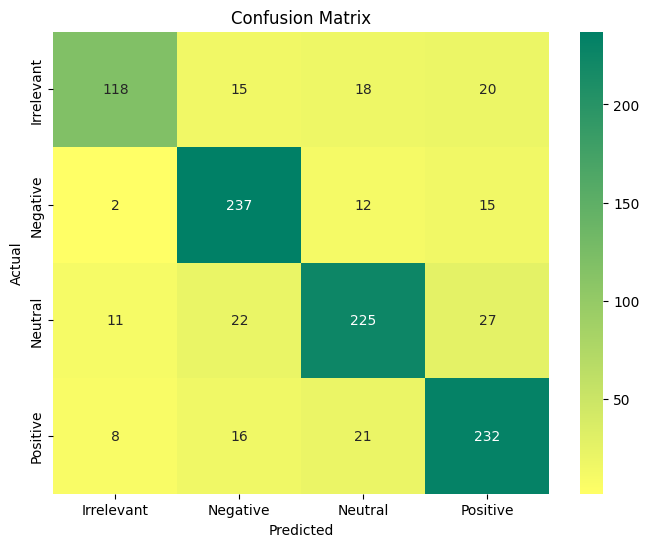

In [13]:
# Plot a confusion matrix with a summer_r colormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, best_y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer_r', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

As expected, the `Irrelevant` class has the lowest precision and recall, while the `Positive` class has the highest precision and recall. The confusion matrix provides a detailed breakdown of the classifier's performance on each class.

And while we are at it, let us also calculate the per-class accuracy for the XGBoost classifier on the validation set.

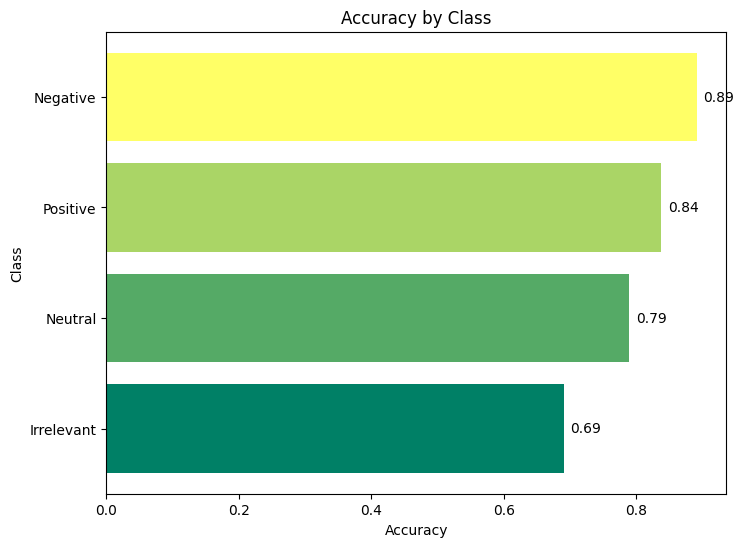

In [14]:
# Plot accuracy for each class
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Calculate accuracy for each class
class_accuracies = {}
for i, class_name in enumerate(best_model.classes_):
    class_accuracies[class_name] = accuracy_score(y_val[y_val == class_name], best_y_val_pred[y_val == class_name])

# Sort classes by accuracy
class_accuracies = dict(sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True))

# Plot accuracy for each class using summer_r colormap
plt.figure(figsize=(8, 6))
colors = plt.cm.summer_r(np.linspace(0, 1, len(class_accuracies)))
bars = plt.barh(list(class_accuracies.keys()), list(class_accuracies.values()), color=colors)

# Add accuracy values to each color bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center')

plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Accuracy by Class')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy at the top
plt.show()

And finally let us evaluate the performance of the XGBoost classifier on a set of entirely new, general sentences. These are sentences that the model has not seen before or which originate from the original dataset, and will help us understand how well the model generalizes to unseen data.

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

# Test sentences with their corresponding true sentiments (Positive/Negative/Neutral/Irrelevant)
test_sentences = [
    ("This ice cream is delicious!", "Positive"),
    ("I hate this phone.", "Negative"),
    ("I love this car.", "Positive"),
    ("I don't like this book.", "Negative"),
    ("This sandwich couldn't be worse!", "Negative"),
    ("I'm in love with this song.", "Positive"),
    ("Why is this happening to me?", "Negative"),
    ("This is the worst day ever.", "Negative"),
    ("Ha! Ha! Ha! This is so funny", "Positive"),
    ("I'm so sad right now.", "Negative"),
    ("That phone really sucks.", "Negative"),
    ("What a fantastic performance!", "Positive"),
    ("This place is amazing!", "Positive"),
    ("I'm extremely disappointed in this service.", "Negative"),
    ("This is the best thing ever!", "Positive"),
    ("I can't stand this anymore.", "Negative"),
    ("This movie is a masterpiece.", "Positive"),
    ("I feel utterly miserable.", "Negative"),
    ("What a wonderful surprise!", "Positive"),
    ("This is a total disaster.", "Negative"),
    ("I'm thrilled with the results.", "Positive"),
    ("I detest this kind of behavior.", "Negative"),
    ("This experience was phenomenal.", "Positive"),
    ("I regret buying this product.", "Negative"),
    ("I'm ecstatic about the news!", "Positive"),
    ("This is utterly ridiculous.", "Negative"),
    ("I couldn't be happier with my decision.", "Positive"),
    ("This is an absolute failure.", "Negative"),
    ("I'm over the moon with joy!", "Positive"),
    ("This is the last straw.", "Negative"),
    ("I'm feeling great today!", "Positive"),
    ("This product is amazing!", "Positive"),
    ("I'm very unhappy with this.", "Negative"),
    ("What a terrible experience!", "Negative"),
    ("This is just perfect.", "Positive"),
    ("I love the way this looks.", "Positive"),
    ("I'm so frustrated right now.", "Negative"),
    ("This is absolutely fantastic!", "Positive"),
    ("I can't believe how bad this is.", "Negative"),
    ("I'm delighted with the outcome.", "Positive"),
    ("This is so disappointing.", "Negative"),
    ("What a lovely day!", "Positive"),
    ("I'm completely heartbroken.", "Negative"),
    ("This is pure bliss.", "Positive"),
    ("I despise this kind of thing.", "Negative"),
    ("I'm overjoyed with the results.", "Positive"),
    ("This is simply dreadful.", "Negative"),
    ("I'm very pleased with this.", "Positive"),
    ("This is a nightmare.", "Negative"),
    ("I'm so happy right now!", "Positive"),
    ("This is not acceptable.", "Negative"),
    ("I'm really enjoying this.", "Positive"),
    ("This is absolutely horrible.", "Negative"),
    ("I love spending time here.", "Positive"),
    ("This is the most frustrating thing ever.", "Negative"),
    ("I'm incredibly satisfied with this.", "Positive"),
    ("This is a complete mess.", "Negative"),
    ("What an extraordinary event!", "Positive"),
    ("This is beyond disappointing.", "Negative"),
    ("I'm elated with my progress.", "Positive"),
    ("This is such a waste of time.", "Negative"),
    ("I'm absolutely thrilled!", "Positive"),
    ("This situation is unbearable.", "Negative"),
    ("I can't express how happy I am.", "Positive"),
    ("This is a total failure.", "Negative"),
    ("I'm so grateful for this opportunity.", "Positive"),
    ("This is driving me crazy.", "Negative"),
    ("I'm in awe of this beauty.", "Positive"),
    ("This is utterly pointless.", "Negative"),
    ("I'm having the time of my life!", "Positive"),
    ("This is so infuriating.", "Negative"),
    ("I absolutely love this place.", "Positive"),
    ("This is the worst experience ever.", "Negative"),
    ("I'm overjoyed to be here.", "Positive"),
    ("This is a huge disappointment.", "Negative"),
    ("I'm very content with this.", "Positive"),
    ("This is the most annoying thing.", "Negative"),
    ("I'm extremely happy with the results.", "Positive"),
    ("This is totally unacceptable.", "Negative"),
    ("I'm so excited about this!", "Positive"),
    ("This is very upsetting.", "Negative"),
    ("The sky is blue.", "Neutral"),
    ("Water is wet.", "Neutral"),
    ("I have a meeting tomorrow.", "Irrelevant"),
    ("The cat is on the roof.", "Neutral"),
    ("I'm planning to go shopping.", "Irrelevant"),
    ("This text is written in English.", "Neutral"),
    ("It's raining outside.", "Neutral"),
    ("I need to buy groceries.", "Irrelevant"),
    ("My favorite color is blue.", "Neutral"),
    ("I watched a movie yesterday.", "Irrelevant"),
    ("Grass is green.", "Neutral"),
    ("The sun rises in the east.", "Neutral"),
    ("I need to finish my homework.", "Irrelevant"),
    ("Birds are chirping.", "Neutral"),
    ("I'm thinking about dinner.", "Irrelevant"),
    ("Trees provide oxygen.", "Neutral"),
    ("I'm planning a trip next week.", "Irrelevant"),
    ("The earth orbits the sun.", "Neutral"),
    ("I have to call my friend.", "Irrelevant"),
    ("The book is on the table.", "Neutral"),
    ("I need to wash the dishes.", "Irrelevant")
]

# Separate the sentences and their true sentiments
sentences, true_sentiments = zip(*test_sentences)

# Generate embeddings for the test sentences
test_embeddings = np.array([get_embedding(sentence) for sentence in sentences])

# Predict the sentiments using the trained model
predictions = best_model.predict(test_embeddings)

# Print the results and calculate accuracy
correct_predictions = 0
for sentence, true_sentiment, prediction in zip(sentences, true_sentiments, predictions):
    is_correct = prediction == true_sentiment
    if is_correct:
        correct_predictions += 1

# Calculate and print the accuracy
accuracy = correct_predictions / len(sentences)
print(f'Accuracy: {accuracy * 100:.2f}%, for {correct_predictions}/{len(sentences)} correct predictions.')


Accuracy: 80.39%, for 82/102 correct predictions.


## Final remarks

In this exploration, we demonstrated the effectiveness of traditional machine learning algorithms when combined with modern text embeddings for sentiment analysis. While deep learning models like BERT have set a high standard in NLP tasks, traditional algorithms such as Random Forest and XGBoost can still achieve competitive performance with significantly lower computational requirements.

Traditional machine learning algorithms are generally faster and require less computational power compared to deep learning models, making them suitable for scenarios where computational resources are limited. Additionally, traditional algorithms offer more transparency, allowing us to better understand how decisions are made. This is particularly valuable in applications where model interpretability is crucial.

When paired with powerful text embeddings like those generated by BERT, traditional machine learning algorithms can deliver strong performance. Our experiments showed that XGBoost, in particular, outperformed Random Forest in terms of accuracy and F1 score on the validation set. The challenge of class imbalance was evident in the lower performance of the "Irrelevant" class, and techniques such as re-sampling, cost-sensitive learning, or refining the model's hyperparameters could further improve performance in future studies.

The methodology presented is practical and can be easily adapted to various text classification problems beyond sentiment analysis. This flexibility underscores the value of combining traditional machine learning algorithms with modern text embeddings.